# Exploratory Data Analysis

## Import of Packages and Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

from scipy import stats

In [2]:
cwd = Path().cwd()
data = cwd / 'Sleep-Health-Lifestyle-Dataset'
data_csv = list(data.iterdir())[0]
df = pd.read_csv(data_csv)

Checking if the data has missing values. Upon checking, only the target has missing values. These missing values will be filled up with "No Sleep Disorder".

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                374 non-null    int64  
 1   Gender                   374 non-null    object 
 2   Age                      374 non-null    int64  
 3   Occupation               374 non-null    object 
 4   Sleep Duration           374 non-null    float64
 5   Quality of Sleep         374 non-null    int64  
 6   Physical Activity Level  374 non-null    int64  
 7   Stress Level             374 non-null    int64  
 8   BMI Category             374 non-null    object 
 9   Blood Pressure           374 non-null    object 
 10  Heart Rate               374 non-null    int64  
 11  Daily Steps              374 non-null    int64  
 12  Sleep Disorder           155 non-null    object 
dtypes: float64(1), int64(7), object(5)
memory usage: 38.1+ KB


In [4]:
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('No Sleep Disorder')

In [5]:
df.sample(10, random_state=42)

,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
329,330,Female,53,Engineer,8.5,9,30,3,Normal,125/80,65,5000,No Sleep Disorder
33,34,Male,31,Doctor,6.1,6,30,8,Normal,125/80,72,5000,No Sleep Disorder
15,16,Male,29,Doctor,6.0,6,30,8,Normal,120/80,70,8000,No Sleep Disorder
325,326,Female,53,Engineer,8.5,9,30,3,Normal,125/80,65,5000,No Sleep Disorder
57,58,Male,32,Doctor,6.0,6,30,8,Normal,125/80,72,5000,No Sleep Disorder
239,240,Male,44,Salesperson,6.4,6,45,7,Overweight,130/85,72,6000,Insomnia
76,77,Male,33,Doctor,6.0,6,30,8,Normal,125/80,72,5000,No Sleep Disorder
119,120,Female,37,Accountant,7.2,8,60,4,Normal,115/75,68,7000,No Sleep Disorder
332,333,Female,54,Engineer,8.4,9,30,3,Normal,125/80,65,5000,No Sleep Disorder
126,127,Male,38,Lawyer,7.3,8,60,5,Normal,130/85,68,8000,No Sleep Disorder


Blood pressure is defined by both systolic and diastolic pressure, therefore it is valid to split it into two columns.

In [6]:
df[['bp_systolic', 'bp_diastolic']] = (df['Blood Pressure']
                                       .str
                                       .split('/', expand=True)
                                       .astype(int))

It makes sense to drop Person ID since this should not impact prediction if a person has sleeping disorder or not. Additionally, since we have already transformed the Blood Pressure column into two, namely bp_systolic and bp_diastolic, the original feature shall be dropped.

In [7]:
df = df.drop(columns=['Person ID', 'Blood Pressure'])

An overview of the statistics of the transformed data.

In [8]:
df.describe(include='all')

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,bp_systolic,bp_diastolic
count,374,374.000000,374,374.000000,374.000000,374.000000,374.000000,374,374.000000,374.000000,374,374.000000,374.000000
unique,2,NaN,11,NaN,NaN,NaN,NaN,4,NaN,NaN,3,NaN,NaN
top,Male,NaN,Nurse,NaN,NaN,NaN,NaN,Normal,NaN,NaN,No Sleep Disorder,NaN,NaN
freq,189,NaN,73,NaN,NaN,NaN,NaN,195,NaN,NaN,219,NaN,NaN
mean,NaN,42.184492,NaN,7.132086,7.312834,59.171123,5.385027,NaN,70.165775,6816.844920,NaN,128.553476,84.649733
std,NaN,8.673133,NaN,0.795657,1.196956,20.830804,1.774526,NaN,4.135676,1617.915679,NaN,7.748118,6.161611
min,NaN,27.000000,NaN,5.800000,4.000000,30.000000,3.000000,NaN,65.000000,3000.000000,NaN,115.000000,75.000000
25%,NaN,35.250000,NaN,6.400000,6.000000,45.000000,4.000000,NaN,68.000000,5600.000000,NaN,125.000000,80.000000
50%,NaN,43.000000,NaN,7.200000,7.000000,60.000000,5.000000,NaN,70.000000,7000.000000,NaN,130.000000,85.000000
75%,NaN,50.000000,NaN,7.800000,8.000000,75.000000,7.000000,NaN,72.000000,8000.000000,NaN,135.000000,90.000000


## Class Distribution

Visualizing the distribution of the different features. The distributions are shown for each feature for the following:

1. Whole dataset,
2. No Sleeping Disorder,
3. Sleep Apnea, and 
4. Insomnia

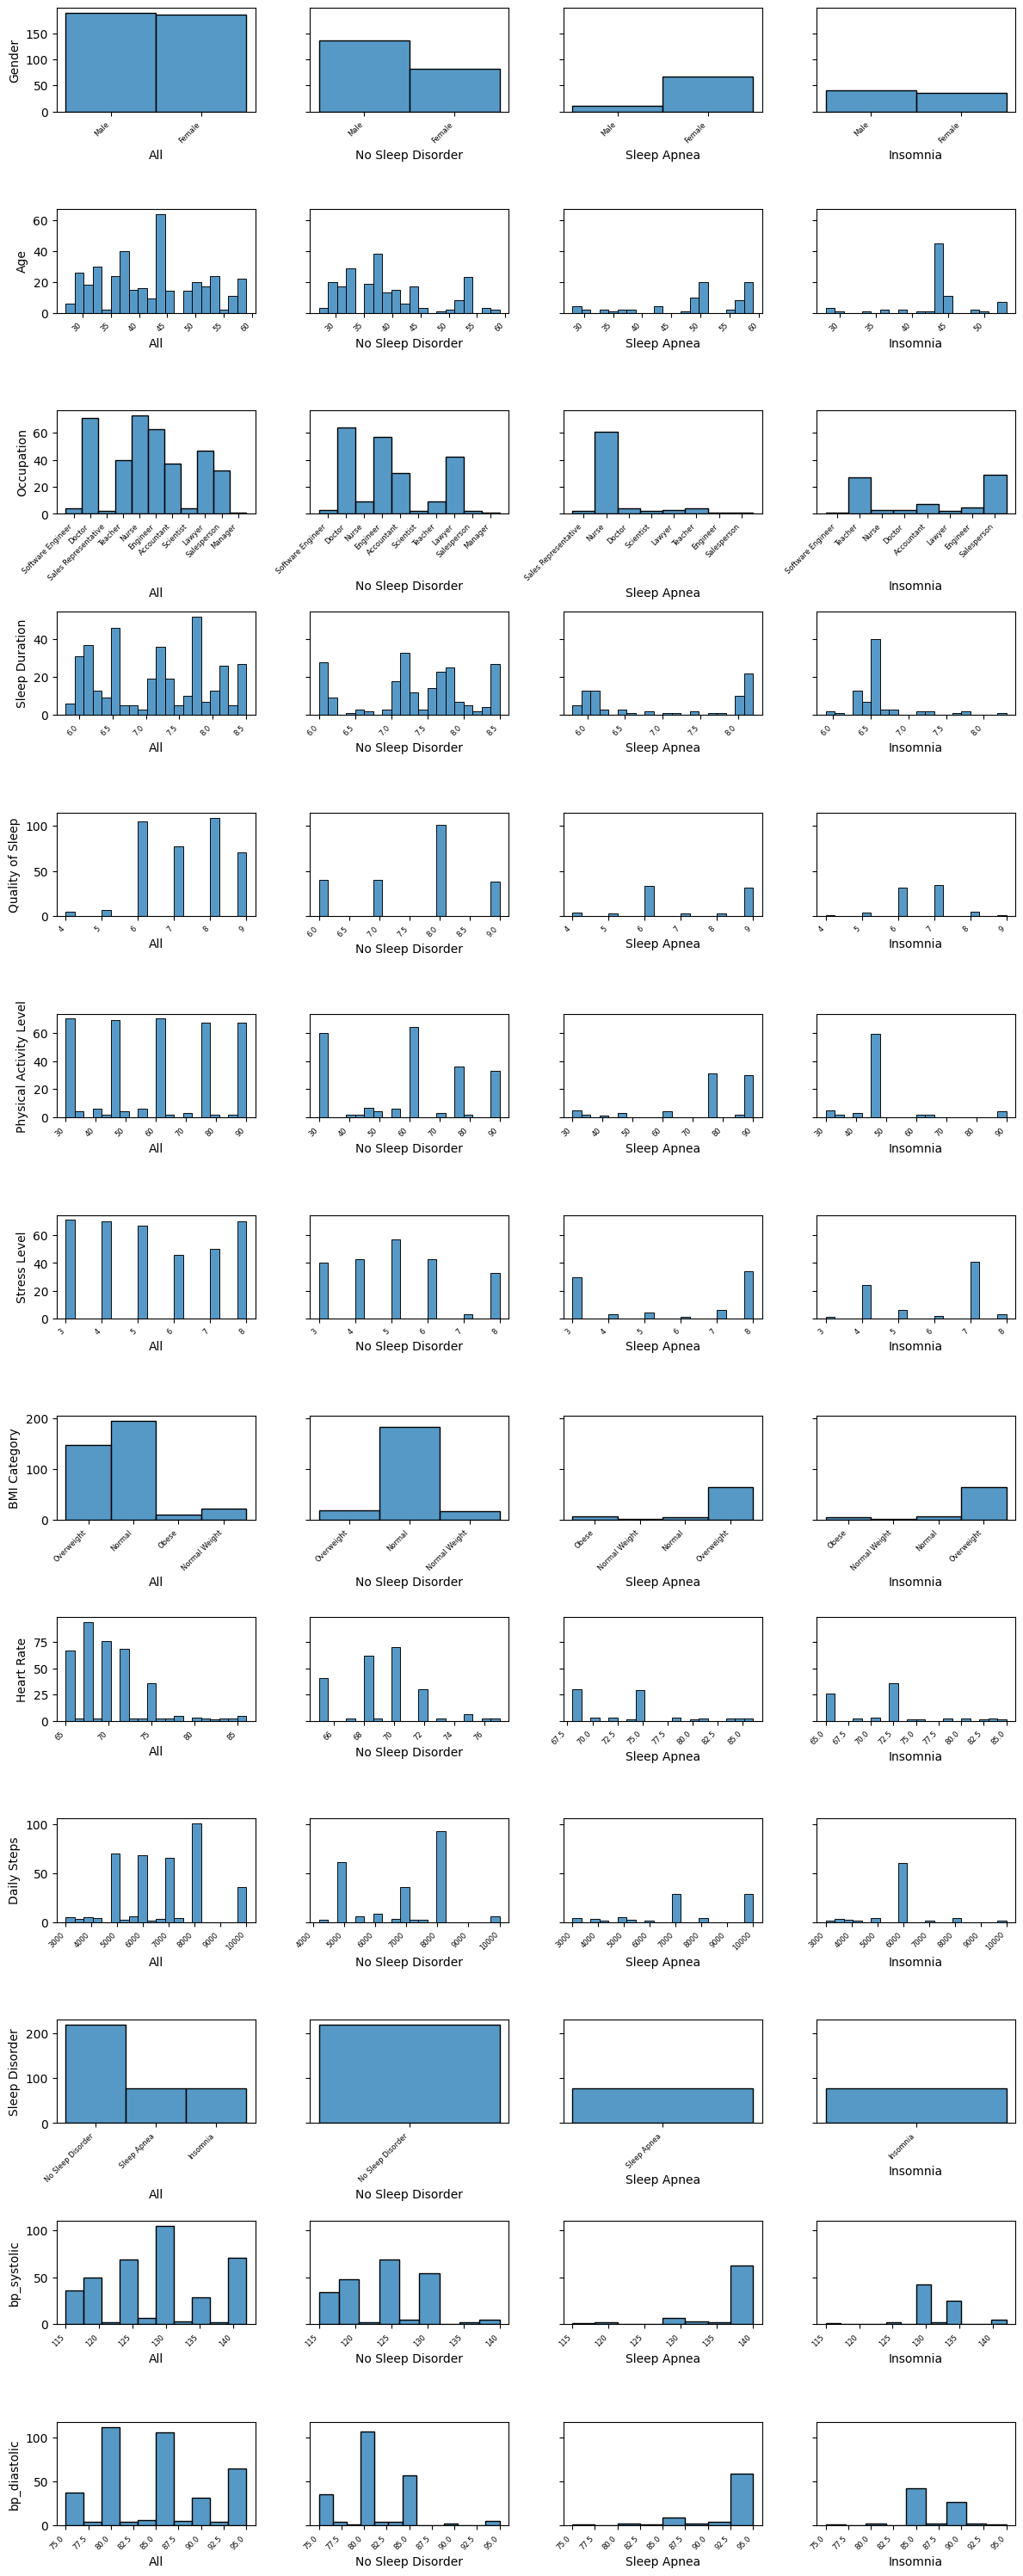

In [9]:
sleep_disorders = ['All'] + df['Sleep Disorder'].unique().tolist()
dataframes = [df] + [df[df['Sleep Disorder'] == x] for x in sleep_disorders[1:]]

x, axes = plt.subplots(nrows=len(df.columns), ncols=4, figsize=(12, 30), sharey='row')
axes = axes.flatten()
col_multiplied = np.array([[x, x, x, x] for x in df.columns]).reshape(-1)
for col, (index, ax)in zip(col_multiplied, enumerate(axes)):
    if (index + 1) % 4 == 1:
        df_use = dataframes[0]
        name = sleep_disorders[0]
    if (index + 1) % 4 == 2:
        df_use = dataframes[1]
        name = sleep_disorders[1]
    if (index + 1) % 4 == 3:
        df_use = dataframes[2]
        name = sleep_disorders[2]
    if (index + 1) % 4 == 0:
        df_use = dataframes[3]
        name = sleep_disorders[3]

    if (df_use[col].dtype == 'int64') or (df_use[col].dtype == 'float64'):
        bins = 20
    else:
        bins = 'auto'

    sns.histplot(df_use, x=col, ax=ax, bins=bins)
    ax.set_ylabel(col, fontsize=10)
    ax.set_xlabel(name, fontsize=10)
    ax.tick_params(axis='x', labelrotation=45, labelsize=6)

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

plt.tight_layout()  

<Axes: >

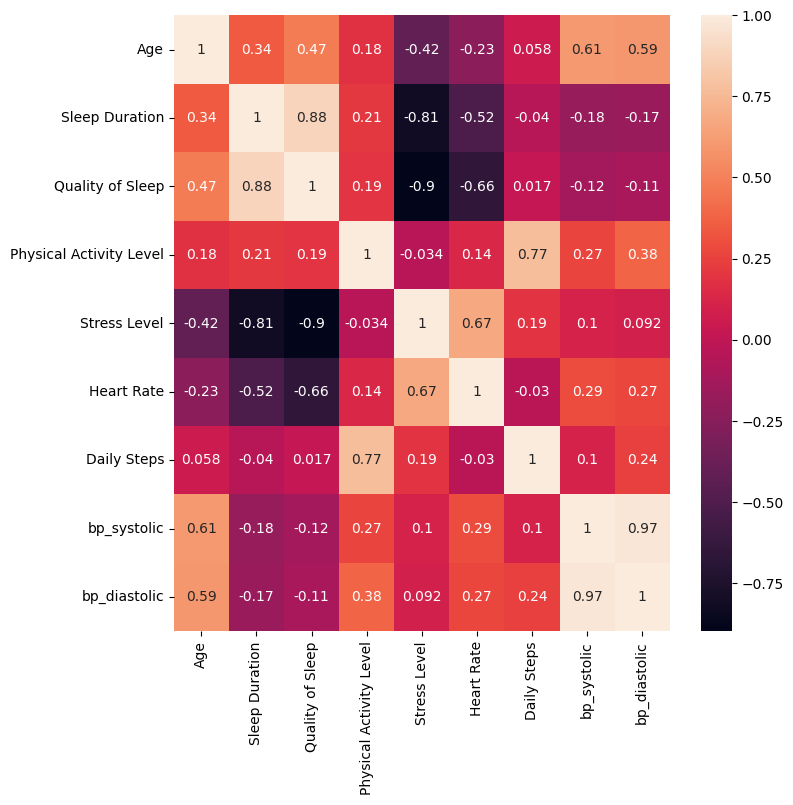

In [10]:
plt.figure(figsize=(8, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True)

Data will be split into features and target where the target is the Sleep Disorder {No Sleep Disorder, Insomnia, Sleep Apnea}.

Additionally, we will randomly split our train and test data in the ratio 7:3.

In [11]:
X = df.copy().drop(columns=['Sleep Disorder'])
y = df['Sleep Disorder'].copy()
display(X.sample(10, random_state=42))
display(y.sample(10, random_state=42))

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,bp_systolic,bp_diastolic
329,Female,53,Engineer,8.5,9,30,3,Normal,65,5000,125,80
33,Male,31,Doctor,6.1,6,30,8,Normal,72,5000,125,80
15,Male,29,Doctor,6.0,6,30,8,Normal,70,8000,120,80
325,Female,53,Engineer,8.5,9,30,3,Normal,65,5000,125,80
57,Male,32,Doctor,6.0,6,30,8,Normal,72,5000,125,80
239,Male,44,Salesperson,6.4,6,45,7,Overweight,72,6000,130,85
76,Male,33,Doctor,6.0,6,30,8,Normal,72,5000,125,80
119,Female,37,Accountant,7.2,8,60,4,Normal,68,7000,115,75
332,Female,54,Engineer,8.4,9,30,3,Normal,65,5000,125,80
126,Male,38,Lawyer,7.3,8,60,5,Normal,68,8000,130,85


329    No Sleep Disorder
33     No Sleep Disorder
15     No Sleep Disorder
325    No Sleep Disorder
57     No Sleep Disorder
239             Insomnia
76     No Sleep Disorder
119    No Sleep Disorder
332    No Sleep Disorder
126    No Sleep Disorder
Name: Sleep Disorder, dtype: object

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3, 
    stratify=y, 
    random_state=42
)

# Baseline Model: Logistic Regression

We will first define a baseline model where no tuning of hyperparameters will be performed. Preprocessing of data is simply applying a OneHotEncoder for the categorical data and StandardScaler for the numerical data.

## Train

In [318]:
object_col = [col for col in df.columns if df[col].dtype == 'object' and col != 'Sleep Disorder']
int_col = [col for col in df.columns if df[col].dtype == 'int64' or df[col].dtype == 'int32']
float_col = [col for col in df.columns if df[col].dtype == 'float64']

In [319]:
preprocess = ColumnTransformer(
    [
        (
            'onehotencoder', 
            OneHotEncoder(
                handle_unknown='infrequent_if_exist', 
                sparse_output=False,
                min_frequency=0.02
            ), 
            object_col
        ),
        (
            'standardscaler', 
            StandardScaler(), 
            float_col + int_col
        )
    ], 
).set_output(transform='pandas')

pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(random_state=42))
])

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(categories='auto',
                                                                drop=None,
                                                                dtype=<class 'numpy.float64'>,
                                                                feature_name_combiner='concat',
                                                                handle_unknown='infrequent_if_exist',
                                                                max_categories=None,
                                                                min_frequency=0.02,
                                                                sparse...
                                                   'Daily Steps', 'bp_systolic',
                                                   'bp_diastolic'])],
                                   verbose=False,
                                   verbose_feature_names_out=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=42,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

## Metrics

In [320]:
pd.DataFrame(
    classification_report(
        y_test, 
        pipeline.predict(X_test), 
        output_dict=True
    )
)

,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.904762,0.984615,0.814815,0.929204,0.901397,0.932298
recall,0.826087,0.969697,0.916667,0.929204,0.904150,0.929204
f1-score,0.863636,0.977099,0.862745,0.929204,0.901160,0.929717
support,23.000000,66.000000,24.000000,0.929204,113.000000,113.000000


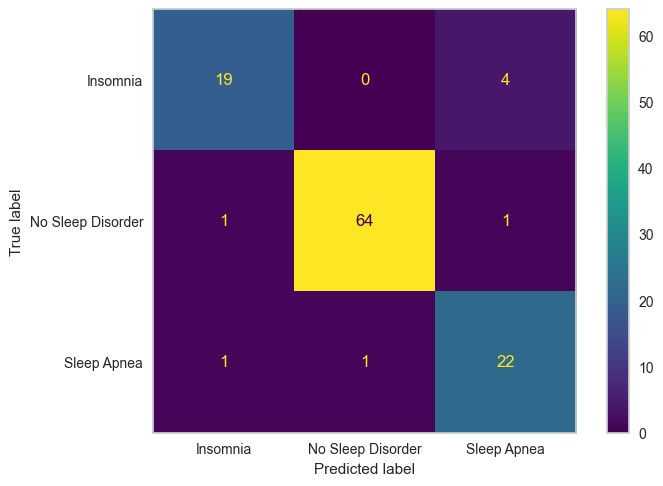

In [322]:
ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)
plt.grid(visible=False);

Based on the results of the baseline model for the test data, we are seeing an accuracy of 92.92% with 8 misclassified out of the 113 test data.

# Model: Optimized Logistic Regression

## Train

In [323]:
preprocess = ColumnTransformer(
    [
        (
            'onehotencoder', 
            OneHotEncoder(
                handle_unknown='infrequent_if_exist', 
                sparse_output=False,
                min_frequency=0.02
            ), 
            object_col
        ),
        (
            'standardscaler', 
            StandardScaler(), 
            float_col + int_col
        )
    ], 
).set_output(transform='pandas')

pipeline = Pipeline([
    ('preprocess', preprocess),
    ('model', LogisticRegression(random_state=42))
])

param_distributions = {
    'model__penalty': [None, 'l1', 'l2', 'elasticnet'],
    'model__C': stats.loguniform(0.01, 100),
    'model__fit_intercept': [True, False],
    'model__intercept_scaling': stats.uniform(0.001, 0.999),
    'model__solver': ['saga'],
    'model__class_weight': [None, 'balanced'],
    'model__max_iter': [1000],
    'model__l1_ratio': stats.uniform(0.001, 0.999),   
}

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

rscv = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=100,
    scoring='f1_weighted',
    cv=cv,
    verbose=0,
    random_state=42,
    return_train_score=True,
    n_jobs=-1
)

rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
                   error_score=nan,
                   estimator=Pipeline(memory=None,
                                      steps=[('preprocess',
                                              ColumnTransformer(n_jobs=None,
                                                                remainder='drop',
                                                                sparse_threshold=0.3,
                                                                transformer_weights=None,
                                                                transformers=[('onehotencoder',
                                                                               OneHotEncoder(categories='auto',
                                                                                             drop=None,
                                                                                             dtype=<class 'numpy.float64'>,
                                                                                             feature...
                                        'model__intercept_scaling': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000126FFBDDC10>,
                                        'model__l1_ratio': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x00000126FAE91210>,
                                        'model__max_iter': [1000],
                                        'model__penalty': [None, 'l1', 'l2',
                                                           'elasticnet'],
                                        'model__solver': ['saga']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=True, scoring='f1_weighted', verbose=0)

In [324]:
rscv.best_params_

{'model__C': 0.8696007095406233,
 'model__class_weight': None,
 'model__fit_intercept': True,
 'model__intercept_scaling': 0.27014292146472296,
 'model__l1_ratio': 0.2448813967255264,
 'model__max_iter': 1000,
 'model__penalty': 'l2',
 'model__solver': 'saga'}

## Metrics

In [325]:
pd.DataFrame(
    classification_report(
        y_test, 
        rscv.best_estimator_.predict(X_test), 
        output_dict=True
    )
)

,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.904762,0.984615,0.814815,0.929204,0.901397,0.932298
recall,0.826087,0.969697,0.916667,0.929204,0.904150,0.929204
f1-score,0.863636,0.977099,0.862745,0.929204,0.901160,0.929717
support,23.000000,66.000000,24.000000,0.929204,113.000000,113.000000


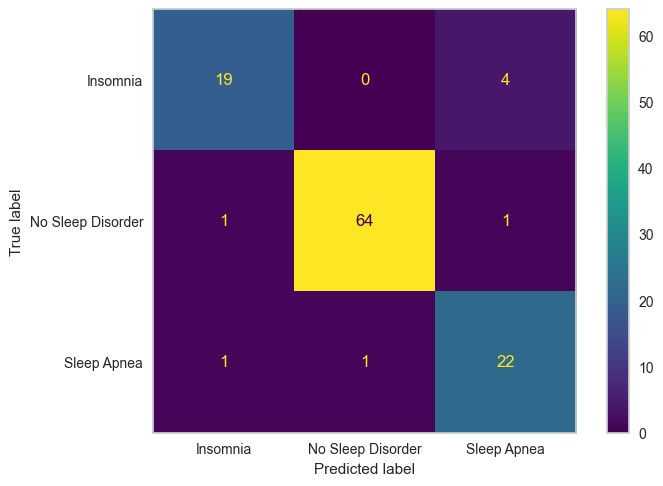

In [327]:
ConfusionMatrixDisplay.from_estimator(rscv.best_estimator_, X_test, y_test)
plt.grid(visible=False);

We have an optimized model where RandomizedSearchCV was used to search for better hyperparameters. The model has maintained accuracy over the test data, having an accuracy of 92.92% with misclassifying 8 out of 113.

# Visualization

In [21]:
# from sklearn.decomposition import PCA
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [22]:
# lda = LinearDiscriminantAnalysis().set_output(transform='pandas')
# df_lda = lda.fit_transform(preprocess.fit_transform(X), y)
# combined = pd.concat([df_lda, pd.Series(y)], axis=1)
# combined

In [23]:
# lda.explained_variance_ratio_.cumsum()

In [24]:
# sns.scatterplot(combined, x='lineardiscriminantanalysis0', y='lineardiscriminantanalysis1', hue='Sleep Disorder')

In [25]:
# import umap

In [26]:
# reducer = umap.UMAP()
# df_umap = reducer.fit_transform(preprocess.fit_transform(X))
# combined_umap = pd.concat([pd.DataFrame(df_umap, columns=['umap0', 'umap1']), pd.Series(y)], axis=1)
# combined_umap

In [27]:
# sns.scatterplot(data=combined_umap, x='umap0', y='umap1', hue='Sleep Disorder')

In [28]:
# from sklearn.manifold import TSNE

In [29]:
# tsne_reducer = TSNE()
# df_tsne = tsne_reducer.fit_transform(preprocess.fit_transform(X))
# combined_tsne = pd.concat([pd.DataFrame(df_tsne, columns=['tsne0', 'tsne1']), pd.Series(y)], axis=1)
# combined_tsne

In [30]:
# sns.scatterplot(data=combined_tsne, x='tsne0', y='tsne1', hue='Sleep Disorder')

In [31]:
# from sklearn.manifold import SpectralEmbedding

In [32]:
# spectral_reducer = SpectralEmbedding()
# df_spectral = spectral_reducer.fit_transform(preprocess.fit_transform(X))
# combined_spectral = pd.concat([pd.DataFrame(df_spectral, columns=['spectral0', 'spectral1']), pd.Series(y)], axis=1)
# combined_spectral

In [33]:
# sns.scatterplot(data=combined_spectral, x='spectral0', y='spectral1', hue='Sleep Disorder')

In [34]:
# def visualize_dimred(manifold_model, X, y):
#     reducer = manifold_model
#     df = reducer.fit_transform(X)
#     combined = pd.concat([pd.DataFrame(df), y], axis=1)
#     display(combined)
#     sns.scatterplot(
#         data=combined, 
#         x=combined.columns[0], 
#         y=combined.columns[1],
#         hue=combined.columns[2]
#     )

In [35]:
# visualize_dimred(TSNE(), preprocess.fit_transform(X), y)

In [ ]:
# from sklearn.manifold import TSNE

In [38]:
# visualize_dimred(TSNE(), preprocess.fit_transform(X), y)

# Pycaret Classification

In [328]:
from pycaret.classification import ClassificationExperiment

In [329]:
s = ClassificationExperiment()
s.setup(
    df,
    target='Sleep Disorder',
    session_id=42,
    train_size=0.7,
    imputation_type=None,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.90,
    # fix_imbalance=True,
    normalize=True,
)

,Description,Value
0,Session id,42
1,Target,Sleep Disorder
2,Target type,Multiclass
3,Target mapping,"Insomnia: 0, No Sleep Disorder: 1, Sleep Apnea: 2"
4,Original data shape,"(374, 13)"
5,Transformed data shape,"(374, 25)"
6,Transformed train set shape,"(261, 25)"
7,Transformed test set shape,"(113, 25)"
8,Numeric features,9
9,Categorical features,3


In [330]:
best = s.compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8967,0.0000,0.8967,0.9039,0.8952,0.8192,0.8243,0.7830
lightgbm,Light Gradient Boosting Machine,0.8967,0.9020,0.8967,0.9061,0.8953,0.8180,0.8240,0.0820
catboost,CatBoost Classifier,0.8929,0.9022,0.8929,0.9029,0.8909,0.8108,0.8176,1.0760
ridge,Ridge Classifier,0.8853,0.0000,0.8853,0.8954,0.8852,0.8000,0.8047,0.0110
lda,Linear Discriminant Analysis,0.8853,0.0000,0.8853,0.8955,0.8851,0.8003,0.8056,0.0110
rf,Random Forest Classifier,0.8852,0.9201,0.8852,0.8943,0.8834,0.7959,0.8024,0.0320
gbc,Gradient Boosting Classifier,0.8852,0.0000,0.8852,0.8968,0.8828,0.7967,0.8046,0.0440
et,Extra Trees Classifier,0.8738,0.9265,0.8738,0.8827,0.8715,0.7768,0.7830,0.0280
knn,K Neighbors Classifier,0.8699,0.9088,0.8699,0.8820,0.8697,0.7707,0.7760,0.2520
svm,SVM - Linear Kernel,0.8698,0.0000,0.8698,0.8859,0.8678,0.7744,0.7822,0.0130


In [222]:
s.evaluate_model(best)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [223]:
s.pipeline

Pipeline(memory=FastMemory(location=C:\Users\Deomary\AppData\Local\Temp\joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('ordinal_encoding',
                 TransformerWrapper(exclude=None, include=['Gender'],
                                    transformer=OrdinalEncoder(cols=['Gender'],
                                                               drop_invariant=False,
                                                               handle_missing='return_na...
                 TransformerWrapper(exclude=[], include=None,
                                    transformer=RemoveMulticollinearity(threshold=0.9))),
                ('normalize',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=StandardScaler(copy=True,
                                                               with_mean=True,
                                                               with_std=True))),
                ('clean_column_names',
                 TransformerWrapper(exclude=None, include=None,
                                    transformer=CleanColumnNames(match='[\\]\\[\\,\\{\\}\\"\\:]+')))],
         verbose=False)

In [333]:
X_train_transformed, y_train_transformed = s.pipeline.transform(X_train, y_train)
X_test_transformed, y_test_transformed = s.pipeline.transform(X_test, y_test)

In [334]:
pd.DataFrame(
    classification_report(
        y_test_transformed, 
        best.predict(X_test_transformed), 
        output_dict=True,
        target_names=s.pipeline['label_encoding'].inverse_transform(best.classes_)
    )
)

,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.875000,0.984127,0.846154,0.929204,0.901760,0.932611
recall,0.913043,0.939394,0.916667,0.929204,0.923035,0.929204
f1-score,0.893617,0.961240,0.880000,0.929204,0.911619,0.930222
support,23.000000,66.000000,24.000000,0.929204,113.000000,113.000000


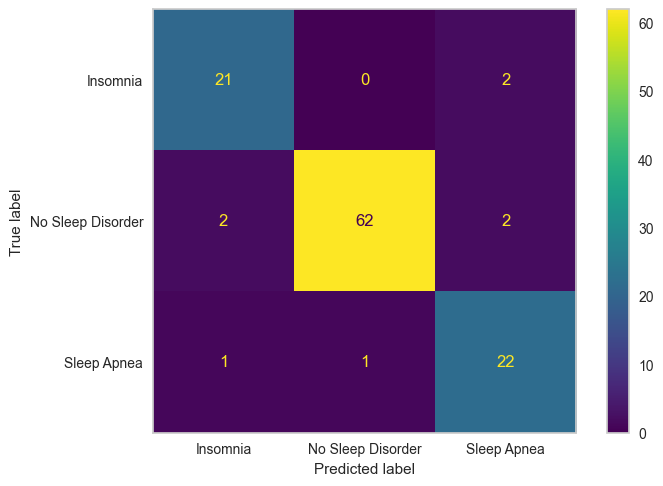

In [335]:
ConfusionMatrixDisplay.from_estimator(
    best, 
    X_test_transformed, 
    y_test_transformed, 
    display_labels=s.pipeline['label_encoding'].inverse_transform(best.classes_)
)
plt.grid(visible=False);

In [336]:
best_tuned = s.tune_model(best, n_iter=300)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8519,0.0000,0.8519,0.8836,0.8566,0.7568,0.7701
1,0.8846,0.0000,0.8846,0.8793,0.8800,0.7953,0.7976
2,0.8846,0.0000,0.8846,0.8958,0.8805,0.7958,0.8024
3,0.9231,0.0000,0.9231,0.9286,0.9224,0.8663,0.8686
4,0.8846,0.0000,0.8846,0.8817,0.8812,0.7953,0.7976
5,0.9615,0.0000,0.9615,0.9639,0.9600,0.9316,0.9344
6,0.9231,0.0000,0.9231,0.9321,0.9216,0.8598,0.8684
7,0.8462,0.0000,0.8462,0.8462,0.8462,0.7333,0.7333
8,0.8846,0.0000,0.8846,0.8891,0.8842,0.7827,0.7854


Fitting 10 folds for each of 300 candidates, totalling 3000 fits


In [130]:
best_tuned.score(X_test_transformed, y_test_transformed)

0.9203539823008849

In [131]:
best.score(X_test_transformed, y_test_transformed)

0.9292035398230089

In [128]:
model_2 = s.create_model('lightgbm')
model_2_tuned = s.tune_model(model_2, n_iter=300)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8519,0.9344,0.8519,0.8836,0.8566,0.7568,0.7701
1,0.8462,0.8700,0.8462,0.8654,0.8322,0.7135,0.7355
2,0.8846,0.7918,0.8846,0.8958,0.8805,0.7958,0.8024
3,0.9231,0.9154,0.9231,0.9286,0.9224,0.8663,0.8686
4,0.8462,0.8799,0.8462,0.8462,0.8462,0.7333,0.7333
5,0.9615,0.9281,0.9615,0.9639,0.9600,0.9316,0.9344
6,0.9231,0.9021,0.9231,0.9321,0.9216,0.8598,0.8684
7,0.8462,0.9088,0.8462,0.8562,0.8494,0.7400,0.7420
8,0.8846,0.8895,0.8846,0.8891,0.8842,0.7827,0.7854


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8519,0.9142,0.8519,0.8836,0.8566,0.7568,0.7701
1,0.8462,0.8514,0.8462,0.8654,0.8322,0.7135,0.7355
2,0.8846,0.8211,0.8846,0.8958,0.8805,0.7958,0.8024
3,0.9231,0.9192,0.9231,0.9286,0.9224,0.8663,0.8686
4,0.8462,0.8673,0.8462,0.8462,0.8462,0.7333,0.7333
5,0.9615,0.9316,0.9615,0.9639,0.9600,0.9316,0.9344
6,0.9231,0.9288,0.9231,0.9321,0.9216,0.8598,0.8684
7,0.8846,0.9200,0.8846,0.8874,0.8841,0.8045,0.8067
8,0.9231,0.8990,0.9231,0.9316,0.9211,0.8506,0.8602


Fitting 10 folds for each of 300 candidates, totalling 3000 fits


In [132]:
model_2_tuned.score(X_test_transformed, y_test_transformed)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


0.9292035398230089

In [136]:
pd.DataFrame(
    classification_report(
        y_test_transformed, 
        model_2_tuned.predict(X_test_transformed), 
        output_dict=True,
        target_names=s.pipeline['label_encoding'].inverse_transform(best.classes_)
    )
)

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.913043,0.955882,0.863636,0.929204,0.910854,0.927571
recall,0.913043,0.984848,0.791667,0.929204,0.896520,0.929204
f1-score,0.913043,0.970149,0.826087,0.929204,0.903093,0.927929
support,23.000000,66.000000,24.000000,0.929204,113.000000,113.000000


[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


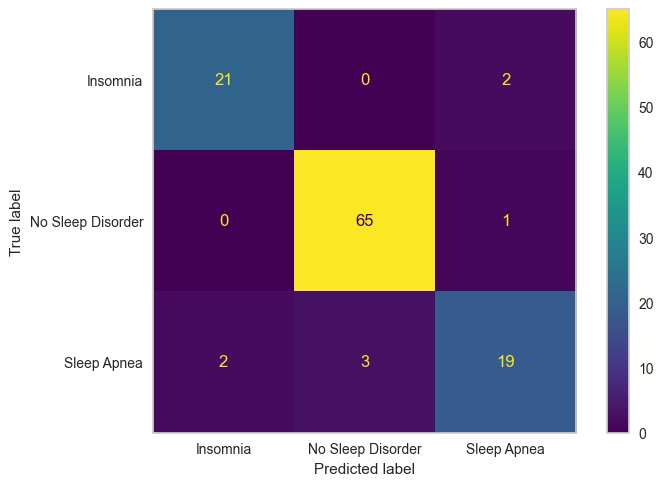

In [139]:
ConfusionMatrixDisplay.from_estimator(
    model_2_tuned, 
    X_test_transformed, 
    y_test_transformed, 
    display_labels=s.pipeline['label_encoding'].inverse_transform(best.classes_)
)
plt.grid(visible=False);

In [133]:
model_3 = s.create_model('catboost')
model_3_tuned = s.tune_model(model_3, n_iter=300)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8519,0.8971,0.8519,0.8836,0.8566,0.7568,0.7701
1,0.8462,0.8911,0.8462,0.8654,0.8322,0.7135,0.7355
2,0.8846,0.8026,0.8846,0.8958,0.8805,0.7958,0.8024
3,0.9231,0.9476,0.9231,0.9286,0.9224,0.8663,0.8686
4,0.8462,0.8638,0.8462,0.8462,0.8462,0.7333,0.7333
5,0.9231,0.9136,0.9231,0.9321,0.9159,0.8595,0.8707
6,0.9231,0.8823,0.9231,0.9321,0.9216,0.8598,0.8684
7,0.8462,0.9248,0.8462,0.8562,0.8494,0.7400,0.7420
8,0.8846,0.8988,0.8846,0.8891,0.8842,0.7827,0.7854


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8519,0.8600,0.8519,0.8836,0.8566,0.7568,0.7701
1,0.8846,0.9170,0.8846,0.8793,0.8800,0.7953,0.7976
2,0.8846,0.8571,0.8846,0.8958,0.8805,0.7958,0.8024
3,0.9231,0.9155,0.9231,0.9286,0.9224,0.8663,0.8686
4,0.8462,0.8780,0.8462,0.8462,0.8462,0.7333,0.7333
5,0.9615,0.9118,0.9615,0.9639,0.9600,0.9316,0.9344
6,0.9231,0.8642,0.9231,0.9321,0.9216,0.8598,0.8684
7,0.8462,0.9111,0.8462,0.8562,0.8494,0.7400,0.7420
8,0.8846,0.8876,0.8846,0.8891,0.8842,0.7827,0.7854


Fitting 10 folds for each of 300 candidates, totalling 3000 fits


In [134]:
model_3_tuned.score(X_test_transformed, y_test_transformed)

0.9203539823008849

In [141]:
pd.DataFrame(
    classification_report(
        y_test_transformed, 
        model_3_tuned.predict(X_test_transformed), 
        output_dict=True,
        target_names=s.pipeline['label_encoding'].inverse_transform(best.classes_)
    )
)

,Insomnia,No Sleep Disorder,Sleep Apnea,accuracy,macro avg,weighted avg
precision,0.833333,0.984848,0.826087,0.920354,0.881423,0.920290
recall,0.869565,0.984848,0.791667,0.920354,0.882027,0.920354
f1-score,0.851064,0.984848,0.808511,0.920354,0.881474,0.920166
support,23.000000,66.000000,24.000000,0.920354,113.000000,113.000000


In [201]:
summary_df = pd.DataFrame(
    {
        'Logistic Regression Base': [
            pipeline['model'].get_params(),
            pipeline.score(X_test, y_test)
        ],
        'Logistic Regression Tuned': [
            rscv.best_estimator_['model'].get_params(),
            rscv.best_estimator_.score(X_test, y_test)
        ],
        'Pycaret Logistic Regression Tuned': [
            best_tuned.get_params(),
            best_tuned.score(X_test_transformed, y_test_transformed)
        ],
        'Light Gradient Boosting Machine Tuned': [
            model_2_tuned.get_params(),
            model_2_tuned.score(X_test_transformed, y_test_transformed)
        ],
        'Catboost Classifier Tuned': [
            model_3_tuned.get_params(),
            model_3_tuned.score(X_test_transformed, y_test_transformed)
        ],
    },
    index=['hyperparameters', 'accuracy']
)

summary_df

[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


,Logistic Regression Base,Logistic Regression Tuned,Pycaret Logistic Regression Tuned,Light Gradient Boosting Machine Tuned,Catboost Classifier Tuned
hyperparameters,"{'C': 1.0, 'class_weight': None, 'dual': False...","{'C': 0.31489116479568624, 'class_weight': Non...","{'C': 0.196, 'class_weight': {}, 'dual': False...","{'boosting_type': 'gbdt', 'class_weight': None...","{'depth': 6, 'l2_leaf_reg': 1, 'border_count':..."
accuracy,0.911504,0.920354,0.920354,0.929204,0.920354


In [202]:
summary_df.to_csv('summary.csv')

# Pycaret Clustering

In [232]:
from pycaret.clustering import ClusteringExperiment

In [260]:
c = ClusteringExperiment()
c.setup(
    X, 
    session_id=42,
    imputation_type=None,
    # remove_multicollinearity=True,
    # multicollinearity_threshold=0.90,
    # fix_imbalance=True,
    normalize=True,
)

,Description,Value
0,Session id,42
1,Original data shape,"(374, 12)"
2,Transformed data shape,"(374, 25)"
3,Numeric features,9
4,Categorical features,3
5,Preprocess,True
6,Imputation type,None
7,Maximum one-hot encoding,-1
8,Encoding method,None
9,Normalize,True


In [274]:
clusterer = c.create_model('kmodes', num_clusters=8)

,Silhouette,Calinski-Harabasz,Davies-Bouldin,Homogeneity,Rand Index,Completeness
0,0.3729,51.5150,1.5844,0,0,0


In [275]:
c.evaluate_model(clusterer)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [337]:
clustered_df = c.assign_model(clusterer)
clustered_labeled_df = pd.concat([clustered_df, y], axis=1)
clustered_labeled_df

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,bp_systolic,bp_diastolic,Cluster,Sleep Disorder
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,126,83,Cluster 1,No Sleep Disorder
1,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,125,80,Cluster 4,No Sleep Disorder
2,Male,28,Doctor,6.2,6,60,8,Normal,75,10000,125,80,Cluster 4,No Sleep Disorder
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,140,90,Cluster 3,Sleep Apnea
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,140,90,Cluster 3,Sleep Apnea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,140,95,Cluster 1,Sleep Apnea
370,Female,59,Nurse,8.0,9,75,3,Overweight,68,7000,140,95,Cluster 1,Sleep Apnea
371,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,140,95,Cluster 1,Sleep Apnea
372,Female,59,Nurse,8.1,9,75,3,Overweight,68,7000,140,95,Cluster 1,Sleep Apnea


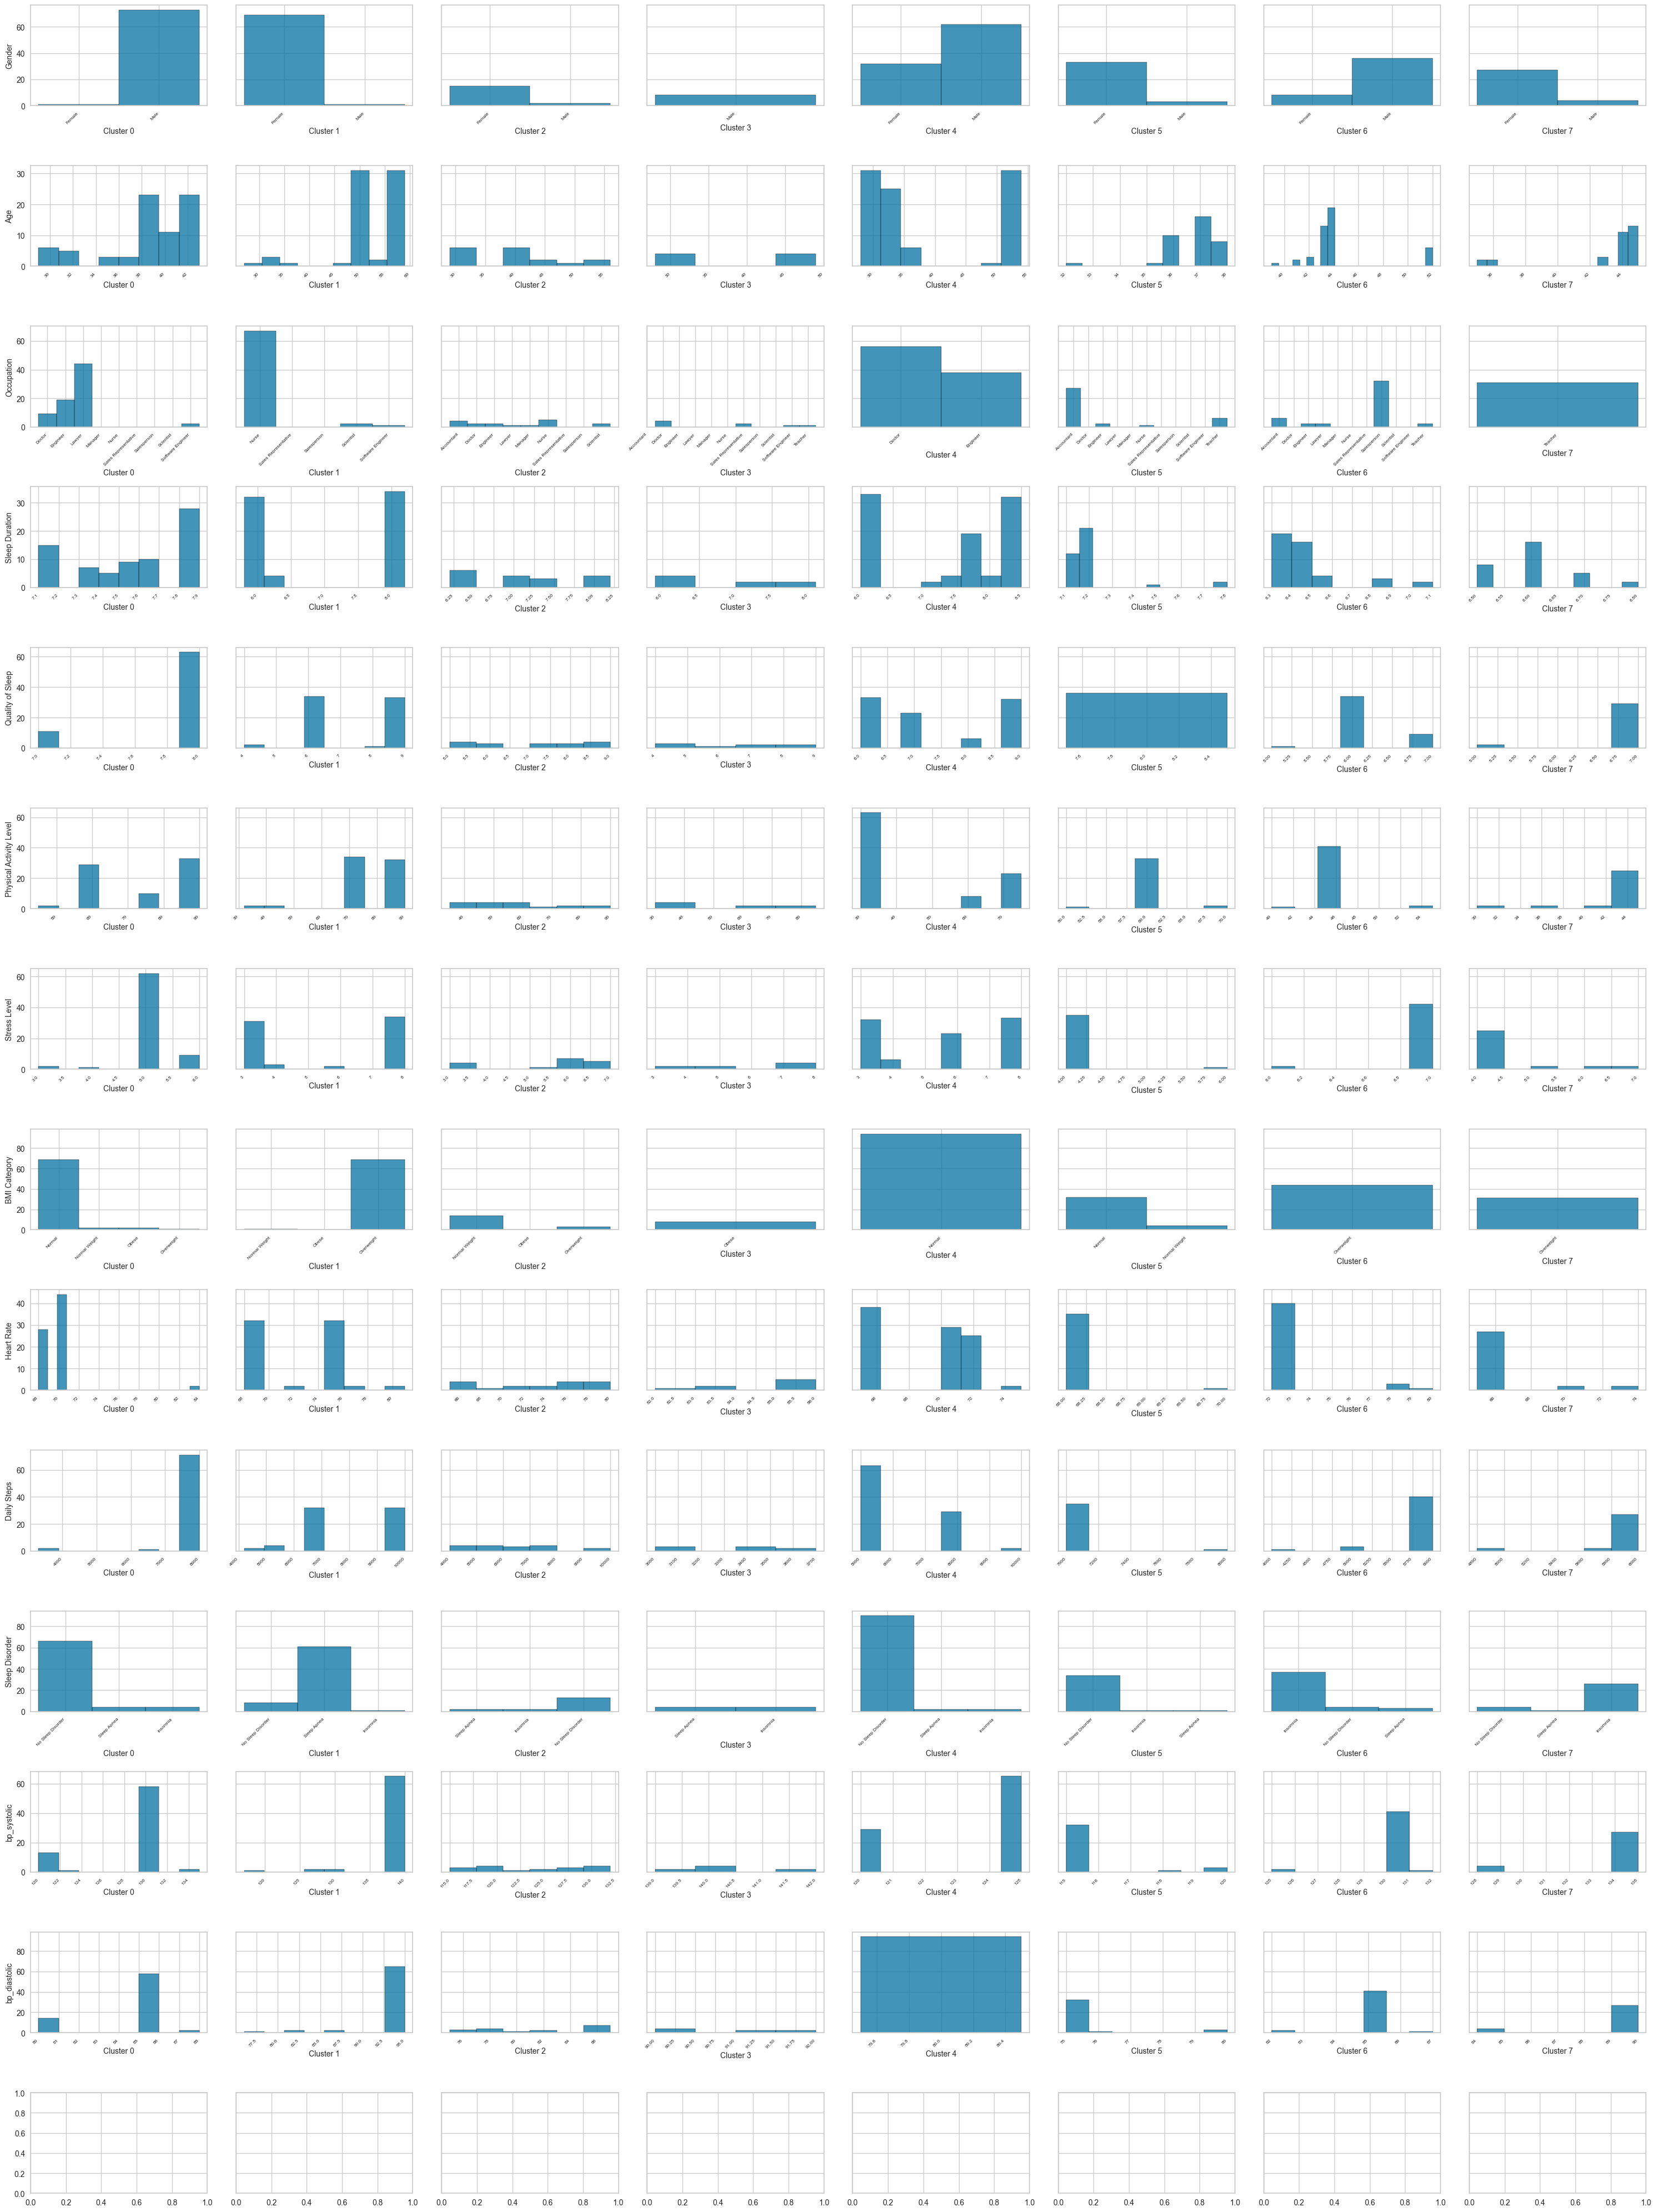

In [338]:
clusters = sorted(clustered_labeled_df['Cluster'].unique().tolist())
dataframes = [clustered_labeled_df[clustered_labeled_df['Cluster'] == x] for x in clusters]

x, axes = plt.subplots(nrows=len(clustered_labeled_df.columns), ncols=8, figsize=(30, 40), sharey='row')
axes = axes.flatten()
col_multiplied = np.array([[x, x, x, x, x, x, x, x] for x in df.columns]).reshape(-1)
for col, (index, ax)in zip(col_multiplied, enumerate(axes)):

    if (index + 1) % 8 == 1:
        df_use = dataframes[0]
        name = clusters[0]
    if (index + 1) % 8 == 2:
        df_use = dataframes[1]
        name = clusters[1]
    if (index + 1) % 8 == 3:
        df_use = dataframes[2]
        name = clusters[2]
    if (index + 1) % 8 == 4:
        df_use = dataframes[3]
        name = clusters[3]

    if (index + 1) % 8 == 5:
        df_use = dataframes[4]
        name = clusters[4]
    if (index + 1) % 8 == 6:
        df_use = dataframes[5]
        name = clusters[5]
    if (index + 1) % 8 == 7:
        df_use = dataframes[6]
        name = clusters[6]
    if (index + 1) % 8 == 0:
        df_use = dataframes[7]
        name = clusters[7]


    if (df_use[col].dtype == 'int64') or (df_use[col].dtype == 'float64'):
        bins = 20
    else:
        bins = 'auto'

    sns.histplot(df_use, x=col, ax=ax, bins=bins)
    ax.set_ylabel(col, fontsize=10)
    ax.set_xlabel(name, fontsize=10)
    ax.tick_params(axis='x', labelrotation=45, labelsize=6)

    for label in ax.get_xticklabels():
        label.set_horizontalalignment('right')

plt.tight_layout()  

In [341]:
pd.concat([preprocess.fit_transform(df), clustered_df['Cluster']], axis=1).groupby('Cluster').mean().to_csv('cluster_summary2.csv')

In [299]:
clustered_df.groupby('Cluster').count()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,bp_systolic,bp_diastolic
Cluster,,,,,,,,,,,,
Cluster 0,74,74,74,74,74,74,74,74,74,74,74,74
Cluster 1,70,70,70,70,70,70,70,70,70,70,70,70
Cluster 2,17,17,17,17,17,17,17,17,17,17,17,17
Cluster 3,8,8,8,8,8,8,8,8,8,8,8,8
Cluster 4,94,94,94,94,94,94,94,94,94,94,94,94
Cluster 5,36,36,36,36,36,36,36,36,36,36,36,36
Cluster 6,44,44,44,44,44,44,44,44,44,44,44,44
Cluster 7,31,31,31,31,31,31,31,31,31,31,31,31


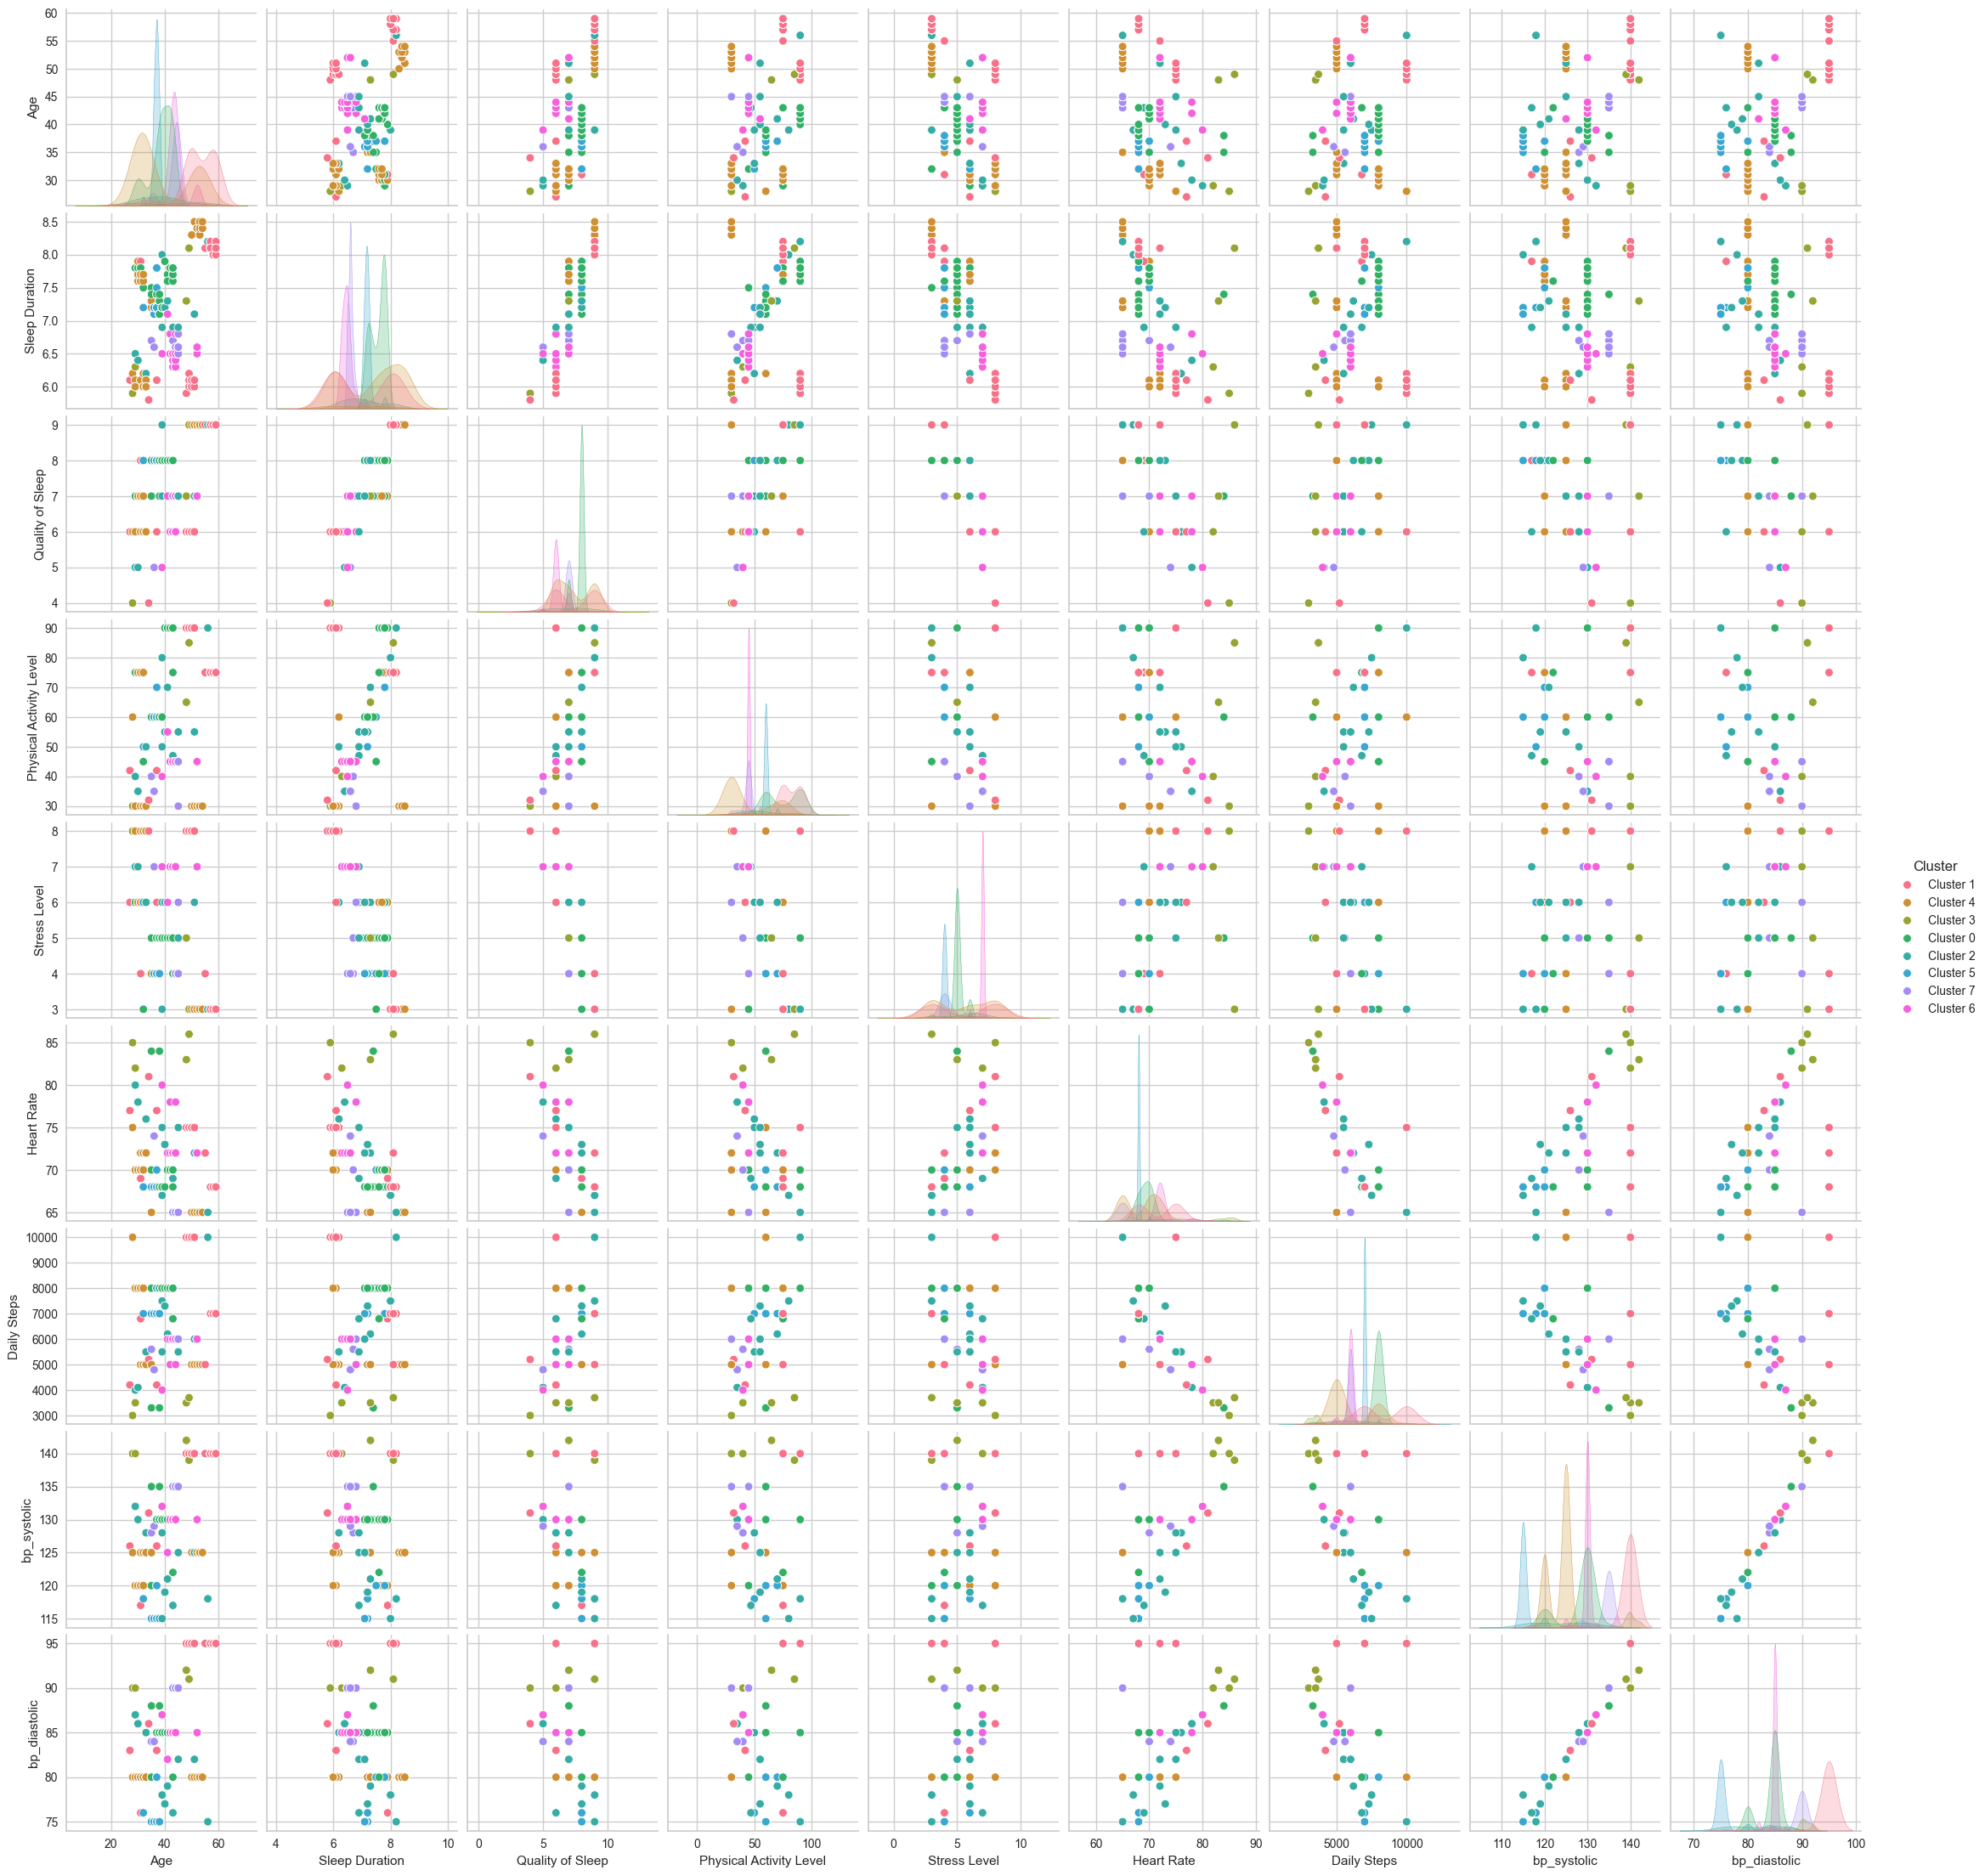

In [300]:
sns.pairplot(clustered_df, hue='Cluster', diag_kind='kde')